Best Fit Curve: y=
            3             2
-9.869e-07 x + 9.806e-05 x - 0.00405 x + 0.1155


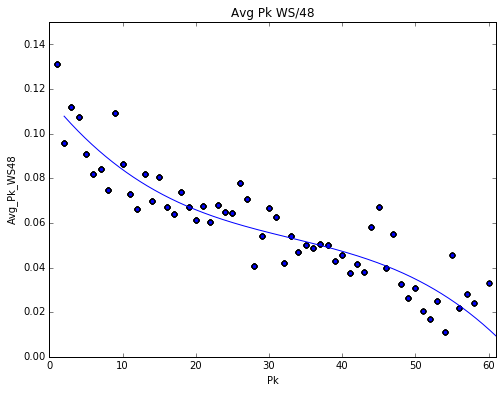

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
%matplotlib inline

df = pd.DataFrame.from_csv('data.csv')
df = df.loc[df['Year'] <= 2015]

df['Avg_Pk_WS48'] = df.groupby('Pk')['WS/48'].transform(lambda x: x.mean())

# Curve fitting seems to do the trick, although I'd like to keep pick 1 without the curve fit
X = df['Pk']
Y = df['Avg_Pk_WS48']
z = np.polyfit(X, Y, 3)   
f = np.poly1d(z)
x_new = np.linspace(2, 61, 500)
y_new = f(x_new)
print "Best Fit Curve: y="
print f
df.plot(y='Avg_Pk_WS48', x='Pk', kind='scatter', \
          title='Avg Pk WS/48', xlim=(0, 61), ylim=(0, 0.15), figsize=(8, 6))
plt.plot(x_new, y_new)

In [2]:
print f[3]

-9.86899657678e-07


In [3]:
df = df.sort_values('Pk')
x = df['Pk']
df['Curve_Fit_Pk_WS48'] = f[3]*(x**3) + f[2]*(x**2) + f[1]*x + f[0]
# Replace #1 
df.loc[df.Pk == 1, ['Curve_Fit_Pk_WS48']] = df['Avg_Pk_WS48']

In [9]:
df = df.sort_values('Pk')
df = df.set_index('Year')

WS = df['WS/48'].groupby(df.index).agg(lambda x: list(list(x)))

cum_list = []
for i in range(1996, 2016):
    mini_list = []
    for j in range(len(WS[i])):
        mini_list.append(WS[i][j:j+7])
    cum_list.append(mini_list)
cum_list = [item for sublist in cum_list for item in sublist]
 
df = df.reset_index().sort_values(['Year', 'Pk'])
simple_transform = [[1, 0.75, 0.55, 0.40, 0.25, 0.15, 0.10, 0.07, 0.05, 0.04, 0.03, 0.02, 0.01] for i in range(len(df))]
print "Sequence:", simple_transform[0]

# for i in range(len(simple_transform)):
#     simple_transform[i][ = .75
    
# print "1/x slight change:", simple_transform[0]
df['Weighted_Following_WS48'] = [sum([y*simple_transform[xi][yi]/sum(simple_transform[0]) for yi,y in enumerate(x)])
                                 for xi,x in enumerate(cum_list)]
df.head(60)

Sequence: [1, 0.75, 0.55, 0.4, 0.25, 0.15, 0.1, 0.07, 0.05, 0.04, 0.03, 0.02, 0.01]


,Year,Url,BPM,BPM_Per_Year,MP,MPG,Pk,Player,Tm,VORP,...,WS_Per_Year,Yrs,Avg_Pk_WS48,Curve_Fit_Pk_WS48,Weighted_Following_WS48,Sliding Scale,Sliding Scale2,Pick Value,Difference,PkDiff
0,1996,http://www.basketball-reference.com/players/i/...,2.7,0.192857,37584.0,41.1,1,Allen Iverson,PHI,44.1,...,7.071429,14.0,0.131250,0.131250,0.115365,0.500000,0.500000,0.123308,0.002692,0.014292
39,1996,http://www.basketball-reference.com/players/c/...,2.9,0.170588,28684.0,29.5,2,Marcus Camby,TOR,35.6,...,4.800000,17.0,0.095900,0.107806,0.113713,0.508475,0.491525,0.110709,0.026291,-0.004305
59,1996,http://www.basketball-reference.com/players/a/...,0.9,0.075000,28882.0,34.8,3,Shareef Abdur-Rahim,VAN,21.1,...,5.933333,12.0,0.112050,0.104228,0.105015,0.516949,0.483051,0.104608,0.013392,0.013206
79,1996,http://www.basketball-reference.com/players/m/...,1.2,0.092308,31891.0,37.7,4,Stephon Marbury,MIN,25.6,...,5.961538,13.0,0.107400,0.100828,0.101930,0.525424,0.474576,0.101351,0.015649,0.013107
98,1996,http://www.basketball-reference.com/players/a/...,3.0,0.166667,46344.0,35.6,5,Ray Allen,MIL,58.1,...,8.061111,18.0,0.090700,0.097601,0.096447,0.533898,0.466102,0.097063,0.052937,0.001011
101,1996,http://www.basketball-reference.com/players/w/...,0.8,0.066667,31531.0,35.3,6,Antoine Walker,BOS,21.9,...,3.175000,12.0,0.081800,0.094540,0.076462,0.542373,0.457627,0.086267,-0.028267,-0.005447
135,1996,http://www.basketball-reference.com/players/w/...,-2.0,-0.153846,18535.0,23.8,7,Lorenzen Wright,LAC,0.0,...,2.346154,13.0,0.084100,0.091640,0.088319,0.550847,0.449153,0.090148,-0.011148,-0.001991
158,1996,http://www.basketball-reference.com/players/k/...,1.9,0.237500,16929.0,33.4,8,Kerry Kittles,BRK,16.9,...,5.600000,8.0,0.074550,0.088895,0.094766,0.559322,0.440678,0.091482,0.035518,-0.009861
162,1996,http://www.basketball-reference.com/players/w/...,-3.0,-0.300000,7612.0,17.1,9,Samaki Walker,DAL,-1.8,...,1.420000,10.0,0.109300,0.086298,0.086798,0.567797,0.432203,0.086514,0.002486,0.024912
180,1996,http://www.basketball-reference.com/players/d/...,0.2,0.012500,24003.0,24.3,10,Erick Dampier,IND,13.1,...,3.293750,16.0,0.086500,0.083844,0.090146,0.576271,0.423729,0.086515,0.018485,0.007602


In [28]:
# Compare more to what's next at the top, avg at bottom with sliding scale
df['Sliding Scale'] = (df['Pk'].astype(float)+58)/118
df['Sliding Scale2'] = 1 - df['Sliding Scale']

df['Pick Value'] = df['Curve_Fit_Pk_WS48']*df['Sliding Scale'] +\
                        df['Weighted_Following_WS48']*df['Sliding Scale2']
df.sort('Pick Value', ascending=False).head(50)[['Year', 'Pk', 'Pick Value']]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Pk,Pick Value
4,2007,1,0.139331
1,1997,1,0.134638
14,2003,1,0.133900
8,2009,1,0.130632
11,2005,1,0.125450
0,1996,1,0.123308
15,2004,1,0.123235
12,2011,1,0.123147
16,2012,1,0.122613
24,2007,2,0.122387


In [31]:
df['Difference'] = df['WS/48'] - df['Pick Value']
df.sort('Difference', ascending=False)[['Year', 'Pk', 'Player', 'Tm', 'Difference']].head(50)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Year,Pk,Player,Tm,Difference
1038,1999,57,Manu Ginobili,SAS,0.174532
785,2014,41,Nikola Jokic,DEN,0.157340
1078,2011,60,Isaiah Thomas,SAC,0.152599
638,2010,33,Hassan Whiteside,SAC,0.147016
536,2013,27,Rudy Gobert,UTA,0.138580
69,2005,4,Chris Paul,NOP,0.136542
925,2006,49,Leon Powe,BOS,0.134271
290,2011,15,Kawhi Leonard,SAS,0.130320
1048,2005,57,Marcin Gortat,ORL,0.127016
883,1999,47,Todd MacCulloch,PHI,0.124267


In [32]:
df.sort('Difference', ascending=False)[['Year', 'Pk', 'Player', 'Tm', 'Difference']].tail(50)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Year,Pk,Player,Tm,Difference
389,2014,20,Bruno Caboclo,TOR,-0.062560
186,2004,10,Luke Jackson,CLE,-0.062805
377,2006,19,Quincy Douby,SAC,-0.064019
99,2015,5,Mario Hezonja,ORL,-0.064416
878,2004,46,Ha Seung-Jin,POR,-0.064446
236,2010,12,Xavier Henry,MEM,-0.064492
222,1999,12,Aleksandar Radojevic,TOR,-0.064647
308,2012,16,Royce White,SAC,-0.067519
649,2004,33,Lionel Chalmers,LAC,-0.067984
587,2009,30,Christian Eyenga,CLE,-0.070644


In [33]:
df_TM = df.groupby('Tm').sum()
df_TM = df_TM.sort('Difference', ascending=False)[['Difference']]
df_TM

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Difference
Tm,
SAS,0.689938
HOU,0.446042
BOS,0.417197
OKC,0.400433
IND,0.373778
UTA,0.334939
GSW,0.284242
NOP,0.255248
TOR,0.234645
